In [1]:
import time
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from utils import load_citation, sgc_precompute, set_seed
from models import get_model
from metrics import accuracy
import pickle as pkl
from args import get_citation_args
from time import perf_counter

# Arguments
args = get_citation_args()

if args.tuned:
    if args.model == "SGC":
        with open("{}-tuning/{}.txt".format(args.model, args.dataset), 'rb') as f:
            args.weight_decay = pkl.load(f)['weight_decay']
            print("using tuned weight decay: {}".format(args.weight_decay))
    else:
        raise NotImplemented

# setting random seeds
set_seed(args.seed, args.cuda)

adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda)

In [2]:
np.sum(adj.data.to_dense().numpy())

2505.3396

In [3]:
adj.shape

torch.Size([2708, 2708])

In [4]:
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import math

In [5]:
def train_regression(model,
                     train_features, train_labels,
                     val_features, val_labels,
                     epochs=args.epochs, weight_decay=args.weight_decay,
                     lr=args.lr, dropout=args.dropout):

    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    t = perf_counter()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_features)
        loss_train = F.cross_entropy(output, train_labels)
        loss_train.backward()
        optimizer.step()

        model.eval()
        output = model(val_features)
        acc_val = accuracy(output, val_labels)
        print(acc_val)
    train_time = perf_counter()-t

    with torch.no_grad():
        model.eval()
        output = model(val_features)
        acc_val = accuracy(output, val_labels)

    return model, acc_val, train_time

def test_regression(model, test_features, test_labels):
    model.eval()
    return accuracy(model(test_features), test_labels)



In [6]:
class SGC(nn.Module):
    """
    A Simple PyTorch Implementation of Logistic Regression.
    Assuming the features have been preprocessed with k-step graph propagation.
    """
    def __init__(self, nfeat, nclass):
        super(SGC, self).__init__()

        self.W = nn.Linear(nfeat, nclass)

    def forward(self, x):
        return self.W(x)

In [7]:
feature_bak = features.clone()

In [8]:
from torch.nn import init

In [6]:
model = SGC(features.size(1),labels.max().item()+1)

In [9]:
degree=6

features = feature_bak.clone()
t_feature = features.clone()
feature_list = [t_feature.clone()]
t = perf_counter()
for i in range(degree):
    t_feature = torch.spmm(adj, t_feature)
    feature_list.append(t_feature.clone())
precompute_time = perf_counter()-t

In [102]:
ws_weight = nn.Parameter(
            torch.FloatTensor(np.random.normal(loc=0.5, scale=0.1, size=(1,degree_size))))

In [103]:
ws_weight

Parameter containing:
tensor([[0.6624, 0.4388, 0.4472, 0.3927, 0.5865, 0.2698, 0.6745]],
       requires_grad=True)

In [101]:
model.ws_weight

Parameter containing:
tensor([0.1000, 0.1000, 0.3000, 0.3000, 0.3000, 0.1000, 0.1000],
       requires_grad=True)

In [104]:
class SGC_WEIGHT_SUM(nn.Module):
    def __init__(self, fea_size, label_size, emb_size, degree_size, fwd_num, drop_rate):
        super(SGC_WEIGHT_SUM, self).__init__()
        self.trans_lin = nn.Linear(fea_size, emb_size)
        init.xavier_uniform_(self.trans_lin.weight)
        self.ws_weight = nn.Parameter(
            torch.FloatTensor([[0.1,0.1,0.3,0.3,0.3,0.1,0.1]]))
#         self.ws_weight = nn.Parameter(
#             torch.FloatTensor(np.random.normal(loc=0.5, scale=0.1, size=(1,degree_size))))
        self.fwd_lin = []
        # Previous Forward Layer
        for i in range(fwd_num-1):
            lin_mod = nn.Linear(emb_size, emb_size)
            init.xavier_uniform_(lin_mod.weight)
            self.fwd_lin.append(lin_mod)
            self.fwd_lin.append(nn.Sigmoid())
        # Final Forward Layer
        lin_mod = nn.Linear(emb_size, label_size)
        init.xavier_uniform_(lin_mod.weight)
        self.fwd_lin.append(lin_mod)
        self.fwd_lin = nn.Sequential(*self.fwd_lin)
        print(self.fwd_lin)
        self.drop = nn.Dropout(drop_rate)
        
        
        
#         self.ws_lin.weight = torch.nn.Parameter(torch.FloatTensor([[1]]))
#         for p in self.ws_lin.parameters():
#             p.requires_grad=False

    def forward(self, x, istrain=False):
        trans_emb = self.trans_lin(x.permute([0,2,1])).permute([0,2,1])
#         ws_emb = torch.squeeze(F.linear(trans_emb,F.softmax(self.ws_weight, dim=1)), dim=-1)
        ws_emb = torch.squeeze(F.linear(trans_emb,self.ws_weight), dim=-1)
#         ws_emb = torch.squeeze(self.ws_lin(trans_emb), dim=-1)
        if istrain:
            ws_emb = self.drop(ws_emb)
        y_pred = self.fwd_lin(ws_emb)
        return y_pred

In [97]:
fea_size = 1433
label_size = 7
emb_size = 128
degree_size = 7
fwd_num = 2
drop_rate = 0.9

In [98]:
features = feature_bak.clone()
t_feature = features.clone()
feature_list = [t_feature.clone()]
t = perf_counter()
for i in range(degree):
    t_feature = torch.spmm(adj, t_feature)
    feature_list.append(t_feature.clone())
precompute_time = perf_counter()-t
feature_list = [torch.unsqueeze(_, dim=-1) for _ in feature_list][0:degree_size]
features = torch.cat(feature_list, dim=-1)

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
set_seed(3, args.cuda)
model = SGC_WEIGHT_SUM(fea_size, label_size, emb_size, degree_size, fwd_num, drop_rate)
print('weight')
print(F.softmax(model.ws_weight, dim=1))
print('train begin')
model, acc_val, train_time, score_array, ws_array = train_regression(
    model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
                 100, args.weight_decay, 1e-3, args.dropout, features[idx_test], labels[idx_test])
acc_test = test_regression(model, features[idx_test], labels[idx_test])

print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))


Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=7, bias=True)
)
weight
tensor([[0.1305, 0.1305, 0.1594, 0.1594, 0.1594, 0.1305, 0.1305]],
       grad_fn=<SoftmaxBackward>)
train begin
[0.13047661, 0.13047661, 0.15936449, 0.15936449, 0.15936449, 0.13047661, 0.13047661]
epoch 0, tr: 14.29, va: 7.20, ts:9.10
epoch 1, tr: 14.29, va: 7.20, ts:9.10
epoch 2, tr: 14.29, va: 7.20, ts:9.10
epoch 3, tr: 14.29, va: 7.20, ts:9.10
epoch 4, tr: 14.29, va: 7.20, ts:9.10
epoch 5, tr: 14.29, va: 5.80, ts:6.40
epoch 6, tr: 14.29, va: 5.80, ts:6.40
epoch 7, tr: 14.29, va: 5.80, ts:6.40
epoch 8, tr: 28.57, va: 15.80, ts:14.50
epoch 9, tr: 27.86, va: 18.20, ts:18.20
[0.13048232, 0.13044377, 0.15934367, 0.15935701, 0.15937154, 0.13049522, 0.13050644]
epoch 10, tr: 28.57, va: 26.00, ts:24.10
epoch 11, tr: 28.57, va: 24.80, ts:22.50
epoch 12, tr: 26.43, va: 22.40, ts:20.30
epoch 13, tr: 23.57, va: 20.20, ts:18.50
epoch 14, tr:

In [95]:
features.shape

torch.Size([2708, 1433, 7])

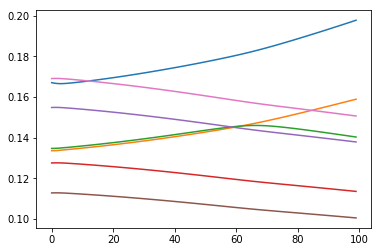

In [24]:
for i in range(ws_array.shape[1]):
    plt.plot(ws_array[:,i])

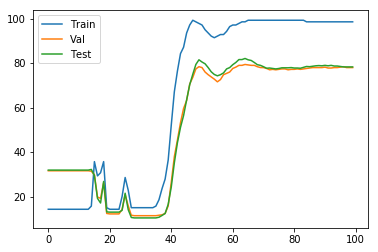

In [474]:
plt.plot(score_array[:,0],score_array[:,1],label='Train')
plt.plot(score_array[:,0],score_array[:,2],label='Val')
plt.plot(score_array[:,0],score_array[:,3],label='Test')
plt.legend()

In [465]:
import pandas as pd

In [467]:
df = pd.DataFrame([[2,2], [2,2]])

In [73]:
set_seed(1, args.cuda)
model = SGC_WEIGHT_SUM(fea_size, label_size, emb_size, degree_size, fwd_num, drop_rate)
print('weight')
print(F.softmax(model.ws_weight, dim=1))
print('train begin')
model, acc_val, train_time, score_array, ws_array = bilevel_train_regression(
    model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
    3, 30, 10, args.weight_decay, 1e-3, args.dropout, features[idx_test], labels[idx_test])
acc_test = test_regression(model, features[idx_test], labels[idx_test])

print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))


Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=7, bias=True)
)
weight
tensor([[0.1671, 0.1336, 0.1348, 0.1276, 0.1549, 0.1129, 0.1691]],
       grad_fn=<SoftmaxBackward>)
train begin
epoch 0(0 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(1 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(2 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(3 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(4 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(5 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(6 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(7 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(8 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(9 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(10 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(11 W), tr: 14.29, va: 31.60, ts:31.90
epoch 0(12 W), tr: 15.71, va: 31.60, ts:32.10
epoch 0(13 W), tr: 28.57, va: 36.20, ts:36.60
epoch 0(14 W), tr: 44.29, va: 39.80, ts:40.10
epoch 0(15 W), tr: 41.43, va: 26.20, ts:25.70
epoch

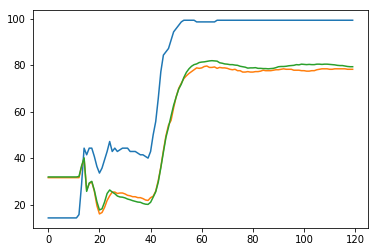

In [77]:
for i in range(3,6):
    plt.plot(score_array[:,i])

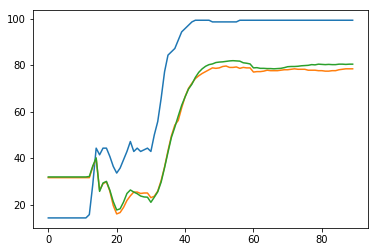

In [78]:
for i in range(3,6):
    plt.plot(score_array[score_array[:,0]==0][:,i])

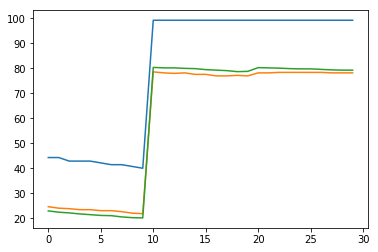

In [76]:
for i in range(3,6):
    plt.plot(score_array[score_array[:,0]==1][:,i])

In [30]:
model.trans_lin.weight

Parameter containing:
tensor([[ 0.0489, -0.0043,  0.0321,  ...,  0.0375, -0.0486, -0.0380],
        [-0.0242, -0.0522, -0.0222,  ...,  0.0077,  0.0218,  0.0305],
        [-0.0130, -0.0573,  0.0467,  ...,  0.0028, -0.0610, -0.0104],
        ...,
        [-0.0243, -0.0453,  0.0009,  ...,  0.0228, -0.0588, -0.0360],
        [-0.0386,  0.0366, -0.0145,  ...,  0.0033,  0.0097,  0.0121],
        [-0.0115, -0.0285, -0.0427,  ...,  0.0315,  0.0588, -0.0240]],
       requires_grad=True)

In [79]:
def bilevel_train_regression(model,
                     train_features, train_labels,
                     val_features, val_labels,
                     total_epochs, w_batchs, a_batchs, weight_decay,
                     lr, dropout, test_features, test_labels):

#     optimizer = optim.Adam(model.parameters(), lr=lr,
#                            weight_decay=weight_decay)

    w_parameters = [model.trans_lin.weight]
    for i,lin in enumerate(model.fwd_lin):
        if i %2 ==1:
            continue
        w_parameters.append(lin.weight)
    alpha_parameters = [model.ws_weight]
    opt_w = optim.Adam(w_parameters, lr=lr,
                           weight_decay=weight_decay)
    opt_a = optim.Adam(alpha_parameters, lr=lr*10,
                           weight_decay=weight_decay)
    
    
    t = perf_counter()
    score_list = []
    ws_list = []
    w_index = 0
    a_index = 0
    for epoch in range(total_epochs):
        for batch in range(w_batchs):
            opt_w.zero_grad()
            output = model(train_features, istrain=True)
            loss_train = F.cross_entropy(output, train_labels)
            loss_train.backward()
            opt_w.step()
        
            output = model(train_features)
            acc_train = float(accuracy(output, train_labels).data.numpy())*100
            model.eval()
            output = model(val_features)
            acc_val = float(accuracy(output, val_labels).data.numpy())*100
            output = model(test_features)
            acc_test = float(accuracy(output, test_labels).data.numpy())*100
            print("epoch %d(%d W), tr: %.2f, va: %.2f, ts:%.2f" %(epoch, batch, acc_train, acc_val, acc_test))
            score_list.append([0, epoch, batch, acc_train, acc_val, acc_test])
        
        for batch in range(a_batchs):
            opt_a.zero_grad()
            output = model(train_features, istrain=True)
            loss_train = F.cross_entropy(output, train_labels)
            loss_train.backward()
            opt_a.step()
            output = model(train_features)
            acc_train = float(accuracy(output, train_labels).data.numpy())*100
            model.eval()
            output = model(val_features)
            acc_val = float(accuracy(output, val_labels).data.numpy())*100
            output = model(test_features)
            acc_test = float(accuracy(output, test_labels).data.numpy())*100
            print("epoch %d(%d A), tr: %.2f, va: %.2f, ts:%.2f" %(epoch, batch, acc_train, acc_val, acc_test))
            score_list.append([1, epoch, batch, acc_train, acc_val, acc_test])
            ws_list.append(list(F.softmax(model.ws_weight, dim=1).data.numpy()[0]))
            print(list(F.softmax(model.ws_weight, dim=1).data.numpy()[0]))
    ws_array = np.array(ws_list)
    score_array = np.array(score_list)
    max_ts_acc_iter = score_array[:, -1].argmax(axis=0)
    max_ts_acc = score_array[max_ts_acc_iter][-1]
    max_va_acc_iter = score_array[:, -2].argmax(axis=0)
    max_va_acc = score_array[max_va_acc_iter][-1]    
    train_time = perf_counter()-t
    print(score_array)
    print('max test acc criterion %.4f' % max_ts_acc)
    print(score_array[max_ts_acc_iter])
    print('max val acc criterion %.4f' % max_va_acc)
    print(score_array[max_va_acc_iter])

#     with torch.no_grad():
#         model.eval()
#         output = model(val_features)
#         acc_val = accuracy(output, val_labels)

    return model, acc_val, train_time, score_array, ws_array

def test_regression(model, test_features, test_labels):
    model.eval()
    return accuracy(model(test_features), test_labels)



In [21]:
def train_regression(model,
                     train_features, train_labels,
                     val_features, val_labels,
                     epochs, weight_decay,
                     lr, dropout, test_features, test_labels):

    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    t = perf_counter()
    score_list = []
    ws_list = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_features, istrain=True)
        ws_list.append(list(F.softmax(model.ws_weight, dim=1).data.numpy()[0]))
        if epoch %10==0:
            print(list(F.softmax(model.ws_weight, dim=1).data.numpy()[0]))
        loss_train = F.cross_entropy(output, train_labels)
        loss_train.backward()
        optimizer.step()
        
        output = model(train_features)
        acc_train = float(accuracy(output, train_labels).data.numpy())*100
        model.eval()
        output = model(val_features)
        acc_val = float(accuracy(output, val_labels).data.numpy())*100
        output = model(test_features)
        acc_test = float(accuracy(output, test_labels).data.numpy())*100
        print("epoch %d, tr: %.2f, va: %.2f, ts:%.2f" %(epoch, acc_train, acc_val, acc_test))
        score_list.append([epoch, acc_train, acc_val, acc_test])
    ws_array = np.array(ws_list)
    score_array = np.array(score_list)
    max_ts_acc_iter = score_array[:, 3].argmax(axis=0)
    max_ts_acc = score_array[max_ts_acc_iter][-1]
    max_va_acc_iter = score_array[:, 2].argmax(axis=0)
    max_va_acc = score_array[max_va_acc_iter][-1]    
    train_time = perf_counter()-t
    print('max test acc criterion %.4f' % max_ts_acc)
    print(score_array[max_ts_acc_iter])
    print('max val acc criterion %.4f' % max_va_acc)
    print(score_array[max_va_acc_iter])

#     with torch.no_grad():
#         model.eval()
#         output = model(val_features)
#         acc_val = accuracy(output, val_labels)

    return model, acc_val, train_time, score_array, ws_array

def test_regression(model, test_features, test_labels):
    model.eval()
    return accuracy(model(test_features), test_labels)



In [449]:
adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda)

In [85]:
feauters_bak = features.clone()

In [86]:
degree = 1

In [87]:
features = feature_bak.clone()
feature_list = [features]
t = perf_counter()
for i in range(degree):
    features = torch.spmm(adj, features)
    feature_list.append(features)
precompute_time = perf_counter()-t

In [89]:
features == feature_bak

tensor([[1, 1, 1,  ..., 1, 0, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)

In [90]:

model = get_model(args.model, features.size(1), labels.max().item()+1, args.hidden, args.dropout, args.cuda)
if args.model == "SGC": features, precompute_time = sgc_precompute(features, adj, args.degree)
    

model, acc_val, train_time = train_regression(model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
                 args.epochs, args.weight_decay, args.lr, args.dropout)
acc_test = test_regression(model, features[idx_test], labels[idx_test])

print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))


tensor(0.5480, dtype=torch.float64)
tensor(0.7140, dtype=torch.float64)
tensor(0.4860, dtype=torch.float64)
tensor(0.5440, dtype=torch.float64)
tensor(0.6980, dtype=torch.float64)
tensor(0.7760, dtype=torch.float64)
tensor(0.7860, dtype=torch.float64)
tensor(0.7720, dtype=torch.float64)
tensor(0.7660, dtype=torch.float64)
tensor(0.7700, dtype=torch.float64)
tensor(0.7660, dtype=torch.float64)
tensor(0.7640, dtype=torch.float64)
tensor(0.7600, dtype=torch.float64)
tensor(0.7640, dtype=torch.float64)
tensor(0.7720, dtype=torch.float64)
tensor(0.7800, dtype=torch.float64)
tensor(0.7840, dtype=torch.float64)
tensor(0.7820, dtype=torch.float64)
tensor(0.7880, dtype=torch.float64)
tensor(0.7880, dtype=torch.float64)
tensor(0.7860, dtype=torch.float64)
tensor(0.7840, dtype=torch.float64)
tensor(0.7780, dtype=torch.float64)
tensor(0.7760, dtype=torch.float64)
tensor(0.7800, dtype=torch.float64)
tensor(0.7840, dtype=torch.float64)
tensor(0.7860, dtype=torch.float64)
tensor(0.7860, dtype=torch.f